In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer
from sklearn.metrics import f1_score

In [2]:
### Constants
seed = 69
cv_size = .3

In [3]:
train = pd.read_csv("data/Train.csv", encoding="ISO-8859-1")
test = pd.read_csv("data/Test.csv", encoding="ISO-8859-1")


In [4]:
for each in train.columns:
    print(each)
    temp = train.groupby(each)[each].nunique()
    print(len(temp))
    
# encode_cols = ["month", "browser", "operatingSystem", "deviceCategory", "continent", 
#               "subContinent", "country", "region", "metro", "city", "medium"]

# other_cols = ["visitNumber","timeSinceLastVisit" "isMobile", "hits", "pageviews", "bounces", "newVisits"]

sessionId
83578
custId
56700
date
366
year
2
month
12
channelGrouping
8
visitStartTime
83428
visitNumber
284
timeSinceLastVisit
24490
browser
29
operatingSystem
15
isMobile
2
deviceCategory
3
continent
5
subContinent
22
country
184
region
322
metro
73
city
501
networkDomain
5645
topLevelDomain
190
campaign
6
source
147
medium
5
keyword
474
isTrueDirect
2
referralPath
446
adContent
25
adwordsClickInfo.page
6
adwordsClickInfo.slot
2
adwordsClickInfo.gclId
1706
adwordsClickInfo.adNetworkType
1
adwordsClickInfo.isVideoAd
1
hits
207
pageviews
159
bounces
1
newVisits
1
revenue
3560


In [5]:
train.head()

,sessionId,custId,date,year,month,channelGrouping,visitStartTime,visitNumber,timeSinceLastVisit,browser,...,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd,hits,pageviews,bounces,newVisits,revenue
0,100000110,1,2016-10-29,2016,10,Social,1477775021,1,0,Chrome,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0
1,400000140,4,2016-09-04,2016,9,Social,1473037945,1,0,Safari,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0
2,500000150,5,2017-07-17,2017,7,Organic Search,1500305542,1,0,Chrome,...,NaN,NaN,NaN,NaN,NaN,5,5.0,NaN,1.0,0.0
3,500000250,5,2017-07-17,2017,7,Organic Search,1500322111,2,16569,Chrome,...,NaN,NaN,NaN,NaN,NaN,3,3.0,NaN,NaN,0.0
4,700000170,7,2016-08-22,2016,8,Social,1471890172,1,0,Safari,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0


In [6]:
train.head()

,sessionId,custId,date,year,month,channelGrouping,visitStartTime,visitNumber,timeSinceLastVisit,browser,...,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd,hits,pageviews,bounces,newVisits,revenue
0,100000110,1,2016-10-29,2016,10,Social,1477775021,1,0,Chrome,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0
1,400000140,4,2016-09-04,2016,9,Social,1473037945,1,0,Safari,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0
2,500000150,5,2017-07-17,2017,7,Organic Search,1500305542,1,0,Chrome,...,NaN,NaN,NaN,NaN,NaN,5,5.0,NaN,1.0,0.0
3,500000250,5,2017-07-17,2017,7,Organic Search,1500322111,2,16569,Chrome,...,NaN,NaN,NaN,NaN,NaN,3,3.0,NaN,NaN,0.0
4,700000170,7,2016-08-22,2016,8,Social,1471890172,1,0,Safari,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0


In [7]:
train.columns

Index(['sessionId', 'custId', 'date', 'year', 'month', 'channelGrouping',
       'visitStartTime', 'visitNumber', 'timeSinceLastVisit', 'browser',
       'operatingSystem', 'isMobile', 'deviceCategory', 'continent',
       'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain',
       'topLevelDomain', 'campaign', 'source', 'medium', 'keyword',
       'isTrueDirect', 'referralPath', 'adContent', 'adwordsClickInfo.page',
       'adwordsClickInfo.slot', 'adwordsClickInfo.gclId',
       'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.isVideoAd', 'hits',
       'pageviews', 'bounces', 'newVisits', 'revenue'],
      dtype='object')

In [8]:
train.shape

(83578, 38)

In [9]:
train.iloc[2]

sessionId                                500000150
custId                                           5
date                                    2017-07-17
year                                          2017
month                                            7
channelGrouping                     Organic Search
visitStartTime                          1500305542
visitNumber                                      1
timeSinceLastVisit                               0
browser                                     Chrome
operatingSystem                            Windows
isMobile                                         0
deviceCategory                             desktop
continent                                 Americas
subContinent                      Northern America
country                                     Canada
region                                         NaN
metro                                          NaN
city                                           NaN
networkDomain                  

In [10]:
min(train["revenue"].values)

0.0

In [11]:
max(train["revenue"].values)

10589.14

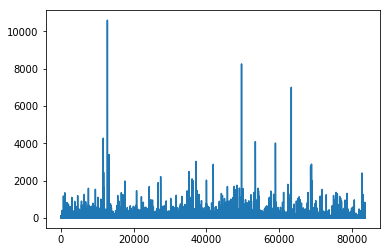

In [12]:
plt.plot(train["revenue"])

In [13]:
X = train.loc[:, train.columns != 'revenue']
y = train["revenue"]

In [14]:
# encode string input values as integers
features = []
encode_cols = ["month", "channelGrouping", "browser", "operatingSystem", "deviceCategory", "continent", 
              "subContinent", "country", "region", "metro", "city", "networkDomain", "topLevelDomain", 
               "campaign", "source", "medium", 
              ]
encode_cols = ["month", "channelGrouping", "browser", "operatingSystem", "deviceCategory", "continent", 
                "subContinent", "country", "region", "metro", "city", "topLevelDomain", "campaign", "source", 
                "medium", "keyword", "referralPath", "adContent", "adwordsClickInfo.page", "adwordsClickInfo.slot",
                "adwordsClickInfo.adNetworkType", "bounces", "newVisits"
              ]

# encode string input values as integers
encoded_x = None
for i in encode_cols:
    col = X[i].apply(str)
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(col.fillna('0'))
    feature = feature.reshape(X.shape[0], 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    feature = onehot_encoder.fit_transform(feature)
    if encoded_x is None:
        encoded_x = feature
    else:
        encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: ", encoded_x.shape)
# encoded_x = np.array(features)
# encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])

X shape:  (83578, 2498)


In [15]:
other_cols = ["visitNumber", "timeSinceLastVisit", "isMobile", "isTrueDirect", "hits", "pageviews"]

In [16]:
X = np.concatenate((X[other_cols].fillna(0), encoded_x), axis=1)

In [17]:
y = Binarizer().transform(y.values.reshape(-1, 1))

In [18]:
print(max(y))
print(min(y))

[1.]
[0.]


In [19]:
print(X.shape)

(83578, 2504)


In [20]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=cv_size)#, random_state=seed)

In [21]:
print(X_train.shape)
print(X_cv.shape)

(58504, 2504)
(25074, 2504)


In [22]:
print(y_train.shape)
print(y_cv.shape)

(58504, 1)
(25074, 1)


In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_cv = pca.transform(X_cv)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [53]:
X_train = pca.fit_transform(X_train)
X_cv = pca.transform(X_cv)

In [54]:
xgtrain = xgb.DMatrix(X_train, y_train)
xgcv = xgb.DMatrix(X_cv, y_cv)

In [59]:
# Specify sufficient boosting iterations to reach a minimum
num_round = 5000
evallist = [(xgcv, 'eval'), (xgtrain, 'train')]
# Leave most parameters as default
param = {'objective': 'binary:logistic',
         'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
         'lambda': 1.5,
         'alpha': .2,
         }
bst = xgb.train(param, xgtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval = 10)

[0]	eval-error:0.058746	train-error:0.050783
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[10]	eval-error:0.050371	train-error:0.040869
[20]	eval-error:0.05065	train-error:0.035707
[30]	eval-error:0.051248	train-error:0.030545
[40]	eval-error:0.051488	train-error:0.026067
[50]	eval-error:0.051527	train-error:0.022016
[60]	eval-error:0.052245	train-error:0.017554
[70]	eval-error:0.052285	train-error:0.014837
[80]	eval-error:0.052485	train-error:0.012597
[90]	eval-error:0.052724	train-error:0.010051
[100]	eval-error:0.053282	train-error:0.007897
[110]	eval-error:0.052485	train-error:0.006102
[120]	eval-error:0.053123	train-error:0.004854
[130]	eval-error:0.053123	train-error:0.003914
[140]	eval-error:0.053601	train-error:0.003231
[150]	eval-error:0.053203	train-error:0.002513
[160]	eval-error:0.052604	train-error:0.001863
[170]	eval-error:0.052724	train-error:0.001402
[180]	eval-error:0.

In [25]:
# model = xgb.XGBClassifier()
# model.fit(X_train, y_train)

In [26]:
# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'binary:logistic'}

# # specify validations set to watch performance
# watchlist = [(xgcv, 'eval'), (xgtrain, 'train')]
# num_round = 2
# bst = xgb.train(param, xgtrain, num_round, watchlist)

In [27]:
bst.save_model('more_feat2000.model')

In [28]:
pred = bst.predict(xgcv)

In [29]:
#plot_pred(bst, xgcv, y_cv)

In [30]:
bin_pred = Binarizer(threshold=0.3).transform(pred.reshape(-1,1))
f1 = f1_score(y_cv, bin_pred)
f1

0.7133943427620631

In [31]:
print(pred)
print(bin_pred)

[1.7427370e-01 8.2866466e-01 2.3261075e-04 ... 2.5949559e-05 6.1422598e-02
 4.9228566e-07]
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [32]:
f1 = f1_score(y_cv, bin_pred)
f1

0.7133943427620631

In [33]:
pred = bst.predict(xgtrain)
bin_pred = Binarizer(threshold=0.4).transform(pred.reshape(-1,1))
f1 = f1_score(y_train, bin_pred)
f1

0.8980780430984274

In [62]:
def plot_pred(model, x, y):
    pred = model.predict(x)
    f1_list = []
    thresholds = np.linspace(0.15, .55, 100)
    for i in thresholds:
        bin_pred = Binarizer(threshold=i).transform(pred.reshape(-1,1))
        f1 = f1_score(y, bin_pred)
        f1_list.append(f1)
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(f1_list)
    return thresholds[np.argmax(f1_list)]

0.545959595959596

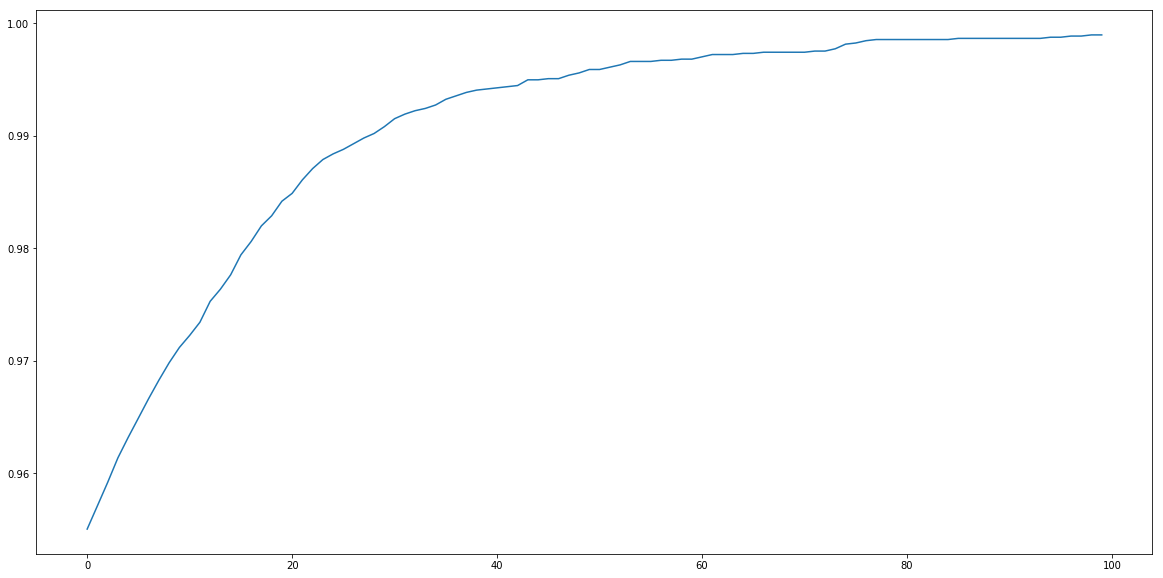

In [63]:
plot_pred(bst, xgtrain, y_train)

0.16616161616161615

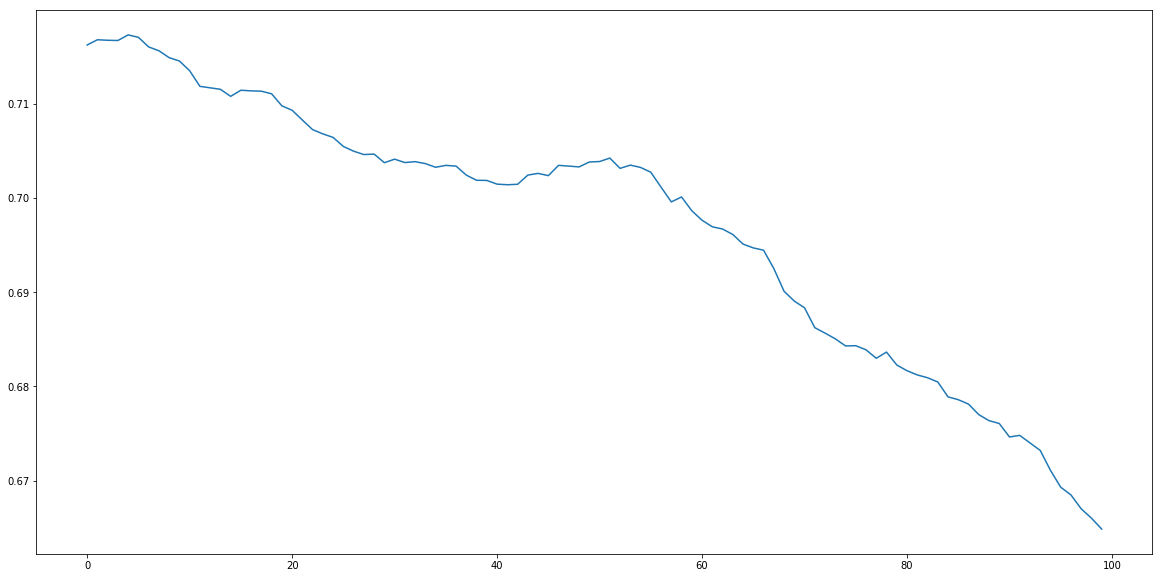

In [58]:
plot_pred(bst, xgcv, y_cv)

In [ ]:
bst.get_fscore()

In [37]:
from bayes_opt import BayesianOptimization

In [38]:
def XGB_CV(
          max_depth,
          gamma,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree,
          lamb,
          alpha
         ):

    global AUCbest
    global ITERbest
    AUCbest = 0
    ITERbest = 0

#
# Define all XGboost parameters
#

    paramt = {
              'booster' : 'gbtree',
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'eta' : 0.1,
              'objective' : 'binary:logistic',
              'nthread' : 4,
              'silent' : False,
#               'eval_metric': 'auc',
              'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
              'lambda': lamb,
              'alpha': alpha,
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'seed' : 1001
              }
    log_file = open('test1.log', 'a')
    folds = 5
    cv_score = 0

    print("\n Search parameters (%d-fold validation):\n %s" % (folds, paramt), file=log_file )
    log_file.flush()

    xgbc = xgb.cv(
                    paramt,
                    xgtrain,
                    num_boost_round = 5000,
                    stratified = True,
                    nfold = folds,
                    verbose_eval = 10,
                    early_stopping_rounds = 100,
#                     metrics = 'error',
                    show_stdv = True
               )
    
#     val_score = xgbc['test-auc-mean'].iloc[-1]
#     train_score = xgbc['train-auc-mean'].iloc[-1]
    val_score = xgbc['test-error-mean'].iloc[-1]
    train_score = xgbc['train-error-mean'].iloc[-1]
    print(' Stopped after %d iterations with train-auc = %f val-auc = %f ( diff = %f ) train-gini = %f val-gini = %f' % ( len(xgbc), train_score, val_score, (train_score - val_score), (train_score*2-1),
    (val_score*2-1)) )
#     if (val_score > AUCbest):
#         AUCbest = val_score
#         ITERbest = len(xgbc)

#     return (val_score*2) - 1
    if (val_score < AUCbest):
        AUCbest = val_score
        ITERbest = len(xgbc)

    return 1 - val_score

In [39]:
XGB_BO = BayesianOptimization(XGB_CV, {
                                     'max_depth': (2, 12),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree': (0.4, 1.0),
                                     'lamb': (1.0, 1.7),
                                     'alpha': (0.0, 0.5)
                                    })

In [40]:
XGB_BO.explore({
              'max_depth':            [3, 8, 3, 8, 8, 3, 8, 3],
              'gamma':                [0.5, 8, 0.2, 9, 0.5, 8, 0.2, 9],
              'min_child_weight':     [0.2, 0.2, 0.2, 0.2, 12, 12, 12, 12],
              'max_delta_step':       [1, 2, 2, 1, 2, 1, 1, 2],
              'subsample':            [0.6, 0.8, 0.6, 0.8, 0.6, 0.8, 0.6, 0.8],
              'colsample_bytree':     [0.6, 0.8, 0.6, 0.8, 0.6, 0.8, 0.6, 0.8],
              'lamb':                 [1.0, 1.0, 1.2, 1.2, 1.4, 1.5, 1.0, 1.3],
              'alpha':                [0.0, 0.0, 0.15, 0.15, 0.25, 0.3, 0.1, 0.15]
              })

In [41]:
XGB_BO.maximize(init_points=2, n_iter=15, acq='ei', xi=0.01)

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |      lamb |   max_delta_step |   max_depth |   min_child_weight |   subsample | 
[0]	train-error:0.0651322+0.00116219	test-error:0.0660126+0.00217393
[10]	train-error:0.0601114+0.00115276	test-error:0.0603888+0.00274001
[20]	train-error:0.0593548+0.000548418	test-error:0.06003+0.00270628
[30]	train-error:0.0578808+0.000808588	test-error:0.0582354+0.00238796
[40]	train-error:0.0562782+0.000628423	test-error:0.0569876+0.00284465
[50]	train-error:0.0551288+0.000626495	test-error:0.0564748+0.00232655
[60]	train-error:0.0545346+0.000297336	test-error:0.0565942+0.00213285
[70]	train-error:0.0538938+0.000322692	test-error:0.0557054+0.00193208
[80]	train-error:0.0531504+0.000297982	test-error:0.0549704+0.00208986
[90]	train-error:0.0524196+0.000455815	t

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.11939752e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00016183]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/zach/dl_env/lib/python3.6/site-packages/bayes_opt/helpers.py:109: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


Bayesian Optimization
----------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |      lamb |   max_delta_step |   max_depth |   min_child_weight |   subsample | 
[0]	train-error:0.0678244+0.000822765	test-error:0.0677218+0.004029
[10]	train-error:0.0609572+0.000820988	test-error:0.0614316+0.00275393
[20]	train-error:0.0603034+0.000679406	test-error:0.0607822+0.00238521
[30]	train-error:0.0591712+0.000654884	test-error:0.0597908+0.00260528
[40]	train-error:0.058624+0.000507793	test-error:0.0594662+0.00296028
[50]	train-error:0.0583206+0.000312783	test-error:0.05897+0.00330832
[60]	train-error:0.0576456+0.000564362	test-error:0.0582694+0.00278426
[70]	train-error:0.0565644+0.00057816	test-error:0.0574318+0.00264159
[80]	train-error:0.0556674+0.000348954	test-error:0.056492+0.00227361
[90]	train-error:0.0547654+0.0002745

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00014898]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0]	train-error:0.0651278+0.000987399	test-error:0.065141+0.00272496
[10]	train-error:0.0601026+0.00111205	test-error:0.0606282+0.00279779
[20]	train-error:0.0567738+0.00127355	test-error:0.0582184+0.00276456
[30]	train-error:0.0546072+0.000823181	test-error:0.0567136+0.00263858
[40]	train-error:0.0530988+0.000610059	test-error:0.0551926+0.00203246
[50]	train-error:0.0521246+0.000321128	test-error:0.0548336+0.00179393
[60]	train-error:0.0509238+0.000406482	test-error:0.0535688+0.00242643
[70]	train-error:0.0501676+0.000354413	test-error:0.0534494+0.00216043
[80]	train-error:0.0496846+0.000277227	test-error:0.0529536+0.00162853
[90]	train-error:0.0489154+0.000354009	test-error:0.052321+0.00186443
[100]	train-error:0.0484368+0.000283276	test-error:0.0521844+0.00169724
[110]	train-error:0.0478128+0.000571907	test-error:0.0520304+0.00164634
[120]	train-error:0.0470182+0.000470937	test-error:0.0515006+0.00173081
[130]	train-error:0.046497+0.00027204	test-error:0.051176+0.00175673
[140]	trai

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00019824]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0]	train-error:0.0378094+0.000370017	test-error:0.0583038+0.00139659
[10]	train-error:0.0308356+0.000351366	test-error:0.0522186+0.00174375
[20]	train-error:0.027246+0.000151943	test-error:0.051193+0.001413
[30]	train-error:0.0249384+0.000303533	test-error:0.0505262+0.00126961
[40]	train-error:0.0229384+0.000284872	test-error:0.050988+0.00106305
[50]	train-error:0.0214046+0.000372843	test-error:0.0505776+0.000954532
[60]	train-error:0.0201654+0.000286856	test-error:0.0507146+0.00115214
[70]	train-error:0.0188492+9.53297e-05	test-error:0.0508682+0.00101464
[80]	train-error:0.0177596+0.000334408	test-error:0.051039+0.00117622
[90]	train-error:0.016691+0.00040014	test-error:0.0510734+0.00145339
[100]	train-error:0.0157984+0.000379624	test-error:0.0510906+0.00133152
[110]	train-error:0.0143366+0.000612847	test-error:0.0511246+0.00160907
[120]	train-error:0.0131572+0.000551484	test-error:0.0510906+0.00166713
[130]	train-error:0.011999+0.000772047	test-error:0.0513296+0.00157653
[140]	train

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.28915678e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0]	train-error:0.083426+0.000159796	test-error:0.085208+0.000708158
[10]	train-error:0.0523084+0.00320695	test-error:0.0597738+0.00240222
[20]	train-error:0.0490822+0.00412636	test-error:0.0571414+0.0035793
[30]	train-error:0.0433434+0.0010546	test-error:0.0532098+0.000912827
[40]	train-error:0.0414886+0.0008099	test-error:0.0522868+0.000497788
[50]	train-error:0.0399674+0.000322357	test-error:0.0518768+0.00106627
[60]	train-error:0.0386298+0.000274147	test-error:0.0517058+0.00119718
[70]	train-error:0.0376384+0.000473509	test-error:0.0513126+0.00104563
[80]	train-error:0.0368736+0.000190545	test-error:0.0505946+0.00135083
[90]	train-error:0.036271+0.000222546	test-error:0.0509708+0.00142105
[100]	train-error:0.0353478+0.000324126	test-error:0.0510564+0.00140018
[110]	train-error:0.0344292+0.000624503	test-error:0.0510048+0.0014526
[120]	train-error:0.033536+0.00036657	test-error:0.0509876+0.00107389
[130]	train-error:0.032844+0.000514634	test-error:0.0512616+0.00139205
[140]	train-er

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.83498614e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0]	train-error:0.0682518+0.000479816	test-error:0.068474+0.00276607
[10]	train-error:0.0605084+0.000711897	test-error:0.0613292+0.00266354
[20]	train-error:0.060047+0.000814367	test-error:0.0606282+0.00226503
[30]	train-error:0.0592696+0.000648588	test-error:0.0596712+0.00262679
[40]	train-error:0.0585432+0.000833325	test-error:0.0592268+0.00259976
[50]	train-error:0.05812+0.000769376	test-error:0.0585428+0.00276009
[60]	train-error:0.057385+0.000589778	test-error:0.0578762+0.00283007
[70]	train-error:0.0566798+0.000614351	test-error:0.0573636+0.00258001
[80]	train-error:0.055667+0.000400904	test-error:0.0566626+0.00223912
[90]	train-error:0.0548766+0.000330074	test-error:0.0560816+0.00209056
[100]	train-error:0.0541542+0.000156742	test-error:0.0557052+0.00169122
[110]	train-error:0.0534278+0.000395892	test-error:0.0552954+0.00165173
[120]	train-error:0.052787+0.000473874	test-error:0.0544578+0.00153776
[130]	train-error:0.0521204+0.000453638	test-error:0.0540986+0.00189485
[140]	trai

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.32557155e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00022724]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.70161499e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0]	train-error:0.0565006+0.000425018	test-error:0.0581156+0.00208557
[10]	train-error:0.0511376+0.000570031	test-error:0.054526+0.00193628
[20]	train-error:0.0493512+0.000287601	test-error:0.0530902+0.00208946
[30]	train-error:0.0481334+0.000461732	test-error:0.0524066+0.00180114
[40]	train-error:0.0469966+0.000342889	test-error:0.0515006+0.00169948
[50]	train-error:0.0461122+0.000477013	test-error:0.0513128+0.00137746
[60]	train-error:0.0456848+0.000352776	test-error:0.0510392+0.00160271
[70]	train-error:0.0448946+0.000462243	test-error:0.0514152+0.00162417
[80]	train-error:0.0444454+0.000316749	test-error:0.0513298+0.00131074
[90]	train-error:0.0439502+0.000272052	test-error:0.050868+0.00140025
[100]	train-error:0.0434328+0.000325429	test-error:0.0511588+0.00164677
[110]	train-error:0.0430186+0.000184315	test-error:0.0513128+0.00152769
[120]	train-error:0.0427064+0.000338667	test-error:0.0513638+0.00137863
[130]	train-error:0.0422022+0.000297048	test-error:0.0509366+0.00124892
[140]

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00033181]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.19776384e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00036114]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0]	train-error:0.050518+0.000558405	test-error:0.0564576+0.000623273
[10]	train-error:0.0436038+0.000400227	test-error:0.0521844+0.0011299
[20]	train-error:0.0411126+0.000237052	test-error:0.050629+0.0013074
[30]	train-error:0.0393052+0.000261007	test-error:0.0503896+0.00173965
[40]	train-error:0.038006+0.00044341	test-error:0.0503894+0.00172813
[50]	train-error:0.0368562+0.000479971	test-error:0.0503042+0.00154327
[60]	train-error:0.0357712+0.000545684	test-error:0.0504924+0.00192948
[70]	train-error:0.0349336+0.000498338	test-error:0.0502872+0.00210629
[80]	train-error:0.0339418+0.000463232	test-error:0.050287+0.00192058
[90]	train-error:0.0330362+0.000461181	test-error:0.0501846+0.00153978
[100]	train-error:0.032066+0.00050927	test-error:0.0503042+0.00159623
[110]	train-error:0.0310962+0.000756976	test-error:0.0505606+0.00177902
[120]	train-error:0.0301688+0.000714883	test-error:0.0504754+0.00177194
[130]	train-error:0.0295536+0.000921021	test-error:0.05068+0.00157581
[140]	train-e

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00083363]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00443593]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0]	train-error:0.0613036+0.000528989	test-error:0.0640126+0.00187144
[10]	train-error:0.0515948+0.00199703	test-error:0.0555176+0.00248245
[20]	train-error:0.0493982+0.001071	test-error:0.0538594+0.0011415
[30]	train-error:0.0470312+0.000755218	test-error:0.0523042+0.00135177
[40]	train-error:0.0457576+0.000859123	test-error:0.0518424+0.00153367
[50]	train-error:0.0451466+0.000755288	test-error:0.051757+0.00160121
[60]	train-error:0.0442108+0.000464858	test-error:0.0512442+0.00152286
[70]	train-error:0.0433858+0.000279664	test-error:0.051364+0.00196693
[80]	train-error:0.0426766+0.000259675	test-error:0.0514834+0.00173504
[90]	train-error:0.0420784+0.000402765	test-error:0.0515008+0.00186854
[100]	train-error:0.0415784+0.00020678	test-error:0.0510392+0.00187858
[110]	train-error:0.0408564+0.000249725	test-error:0.051022+0.00164446
[120]	train-error:0.040305+0.000369538	test-error:0.0511246+0.00186779
[130]	train-error:0.0397366+0.000262785	test-error:0.051193+0.00169943
[140]	train-er

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0001127]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00097201]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


[0]	train-error:0.066722+0.00122421	test-error:0.0672944+0.00405939
[10]	train-error:0.0604446+0.000539263	test-error:0.0604402+0.0028279
[20]	train-error:0.059453+0.00094479	test-error:0.0597564+0.00242201
[30]	train-error:0.0587952+0.000677555	test-error:0.0593288+0.0025641
[40]	train-error:0.058462+0.000592432	test-error:0.0589534+0.00261418
[50]	train-error:0.0579704+0.000754248	test-error:0.0580816+0.00303406
[60]	train-error:0.0574106+0.00070778	test-error:0.0575342+0.00246264
[70]	train-error:0.0562658+0.000704172	test-error:0.0567138+0.002049
[80]	train-error:0.0553294+0.000760202	test-error:0.0560644+0.00149977
[90]	train-error:0.0546674+0.000821156	test-error:0.0553294+0.00135899
[100]	train-error:0.0537912+0.000698646	test-error:0.054885+0.0016805
[110]	train-error:0.0531202+0.00050825	test-error:0.054492+0.00170458
[120]	train-error:0.0525564+0.000311973	test-error:0.0538252+0.00196639
[130]	train-error:0.051881+0.000580311	test-error:0.0533296+0.00156146
[140]	train-error:

/home/zach/dl_env/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00196316]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [ ]:
plot_pred(bst, xgtrain, y_train)

In [45]:
max_depth = 5
gamma = 1
min_child_weight = 2
max_delta_step = 4
subsample = .6
colsample_bytree = .6
lamb = 1.2
alpha = .1

# 'gamma': (0.001, 10.0),
#  'min_child_weight': (0, 20),
#  'max_delta_step': (0, 10),
#  'subsample': (0.4, 1.0),
#  'colsample_bytree': (0.4, 1.0),

#
# Define all XGboost parameters
#

paramt = {
          'booster' : 'gbtree',
          'max_depth' : int(max_depth),
          'gamma' : gamma,
          'eta' : 0.1,
          'objective' : 'binary:logistic',
          'nthread' : 4,
          'silent' : False,
#               'eval_metric': 'auc',
          'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
          'lambda': lamb,
          'alpha': alpha,
          'subsample' : max(min(subsample, 1), 0),
          'colsample_bytree' : max(min(colsample_bytree, 1), 0),
          'min_child_weight' : min_child_weight,
          'max_delta_step' : int(max_delta_step),
#           'seed' : 1001
          }
log_file = open('test.log', 'a')
folds = 5
cv_score = 0

print("\n Search parameters (%d-fold validation):\n %s" % (folds, paramt), file=log_file )
log_file.flush()

xgbc = xgb.cv(
                paramt,
                xgtrain,
                num_boost_round = 5000,
                stratified = True,
                nfold = folds,
                verbose_eval = 10,
                early_stopping_rounds = 100,
#                     metrics = 'error',
                show_stdv = True
           )

[0]	train-error:0.057855+0.000422425	test-error:0.0597052+0.00257705
[10]	train-error:0.0556158+0.000737966	test-error:0.057654+0.00236559
[20]	train-error:0.0529068+0.000681979	test-error:0.055261+0.00290485
[30]	train-error:0.0512314+0.000336795	test-error:0.0539278+0.00230592
[40]	train-error:0.0496634+0.00045969	test-error:0.0529022+0.00194403
[50]	train-error:0.0486162+0.00063626	test-error:0.052099+0.00211236
[60]	train-error:0.047702+0.000778657	test-error:0.0514838+0.00217835
[70]	train-error:0.0469496+0.000594156	test-error:0.0510734+0.00168253
[80]	train-error:0.0460098+0.000372364	test-error:0.0510734+0.00165525
[90]	train-error:0.0450354+0.000336874	test-error:0.0510562+0.00193909
[100]	train-error:0.044386+0.00056975	test-error:0.0509194+0.00187527
[110]	train-error:0.0435868+0.000722507	test-error:0.050304+0.00147786
[120]	train-error:0.0429588+0.000559094	test-error:0.0501332+0.00157912
[130]	train-error:0.0424672+0.000506723	test-error:0.0497402+0.00147652
[140]	train-e

In [47]:
xgbc

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.057855,0.000422,0.059705,0.002577
1,0.057799,0.000774,0.059859,0.001674
2,0.058983,0.002692,0.060628,0.000439
3,0.057876,0.002031,0.060064,0.003220
4,0.059470,0.004823,0.061278,0.005774
5,0.057590,0.002067,0.059175,0.003988
6,0.057300,0.000910,0.058987,0.001990
7,0.056475,0.000554,0.058594,0.002538
8,0.056902,0.001615,0.059244,0.000719
9,0.056488,0.000942,0.058577,0.001689


In [46]:
pred = xgbc.predict(xgtrain)

AttributeError: 'DataFrame' object has no attribute 'predict'

In [52]:
# use below for later - scales test

In [38]:
# encode string input values as integers
features = []
encoded_x = None
for i in encode_cols:
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(test[i].fillna('0'))
	feature = feature.reshape(test.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: ", encoded_x.shape)
# encoded_x = np.array(features)
# encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])
X = np.concatenate((test[other_cols].fillna(0), encoded_x), axis=1)

X shape:  (56208, 1049)
